## 3. Empirical Cumulative Outlier Detection (ECOD)

In [1]:
!pip install pyod
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.1-py3-none-any.whl size=193258 sha256=88124498517065d35b554b825c2202b4746504ab186b36131d53fa0718cd1110
  Stored in directory: /root/.cache/pip/wheels/94/75/88/b853cf33b0053b0a001dca55b74d515048b7656e736364eb57
Successfully built pyod


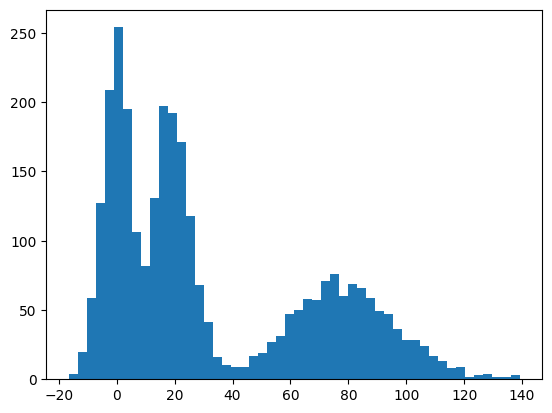

In [3]:
# Create a distribution that is the combination of three other distributions
from matplotlib import pyplot
from numpy.random import normal, gamma
from numpy import hstack
shape, scale = 10, 2.
s1 = gamma(shape, scale, 1000)
s2 = gamma(shape * 2, scale * 2, 1000)
s3 = normal(loc=0, scale=5, size=1000)
sample = hstack((s1, s2, s3))
# plot the histogram
pyplot.hist(sample, bins=50)
pyplot.show()

In [25]:
##################################
# User-defined utility functions #
##################################

def count_stat(vector):
    # Because it is '0' and '1',
    # we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

def descriptive_stat_threshold(df, pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df.columns = feature_list
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold,
                 'Normal', 'Outlier')
    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    # The count and count %
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
    # The average
    stat = df.groupby('Group').mean().round(2).reset_index()
    # Put the count and the average together
    stat = cnt.merge(stat, left_on='Group', right_on='Group')
    return (stat)

def confusion_matrix_threshold(
    actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)

def confusion_matrix(actual,pred):
    Actual_pred = pd.DataFrame({'Actual': actual,'Pred': pred})
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)

def plot_data():
    plt.scatter(X_train_pd[0], X_train_pd[1],c=y_train, alpha=0.8)
    plt.title('Scatter plot')
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.show()

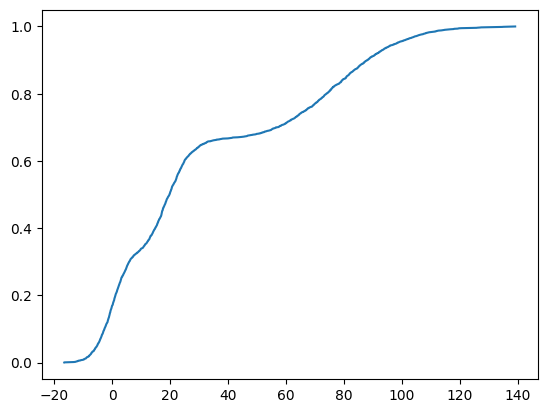

In [5]:
# fit a cdf
from statsmodels.distributions.empirical_distribution import ECDF
sample_ecdf = ECDF(sample)

# plot the cdf
pyplot.plot(sample_ecdf.x, sample_ecdf.y)
pyplot.show()

In [6]:
print('P(x<-20): %.4f' % sample_ecdf(-20))
print('P(x<-2): %.4f' % sample_ecdf(-2))
print('P(x<0): %.4f' % sample_ecdf(0))
print('P(x<25): %.4f' % sample_ecdf(25))
print('P(x<50): %.4f' % sample_ecdf(50))
print('P(x<75): %.4f' % sample_ecdf(75))
print('P(x<100): %.4f' % sample_ecdf(100))
print('P(x<125): %.4f' % sample_ecdf(125))
print('P(x<140): %.4f' % sample_ecdf(140))
print('P(x<150): %.4f' % sample_ecdf(150))

P(x<-20): 0.0000
P(x<-2): 0.1150
P(x<0): 0.1700
P(x<25): 0.6020
P(x<50): 0.6803
P(x<75): 0.8070
P(x<100): 0.9560
P(x<125): 0.9953
P(x<140): 1.0000
P(x<150): 1.0000


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train,
    n_test=n_test,
    n_features= n_features,
    contamination=contamination,
    random_state=123)

X_train = 5 - X_train
X_test = 5 - X_test
X_train_pd = pd.DataFrame(X_train)
X_test_pd = pd.DataFrame(X_test)
X_train_pd.head()

,0,1,2,3,4,5
0,2.603910,2.907389,2.926608,3.011738,3.046527,2.549003
1,3.368960,3.253818,3.101950,2.619852,3.032668,3.141084
2,3.175317,2.868588,2.971171,3.296546,2.497034,2.880892
3,2.893902,2.834827,2.659174,2.829891,3.250861,3.321339
4,3.170353,3.224404,3.170562,2.945232,3.422810,3.405451


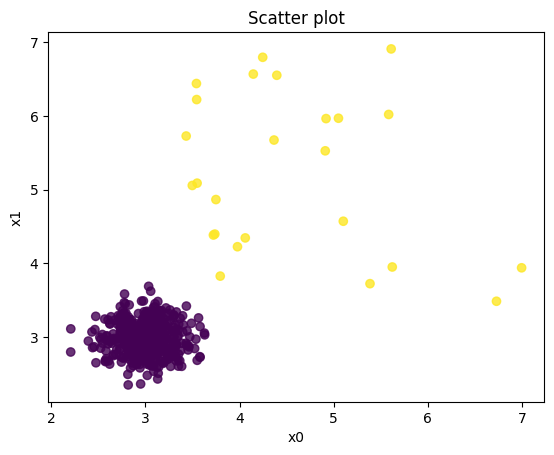

In [8]:
plot_data()

### Step 1: Build the model

In [9]:
from pyod.models.ecod import ECOD
ecod = ECOD() #contamination=0.05)
ecod.fit(X_train)

# Training data
y_train_scores = ecod.decision_function(X_train)
y_train_pred = ecod.predict(X_train)

# Test data
y_test_scores = ecod.decision_function(X_test)
y_test_pred = ecod.predict(X_test) # outlier labels (0 or 1)

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))
print("The threshold for the defined contamination rate:" , ecod.threshold_)

The training data: {0: 450, 1: 50}
The training data: {0: 444, 1: 56}
The threshold for the defined contamination rate: 12.75035460032711


In [10]:
ecod.threshold_

12.75035460032711

In [11]:
pick_outliers = np.where(y_train_scores>24)
pick_outliers[0]

array([475, 477, 483, 488, 490])

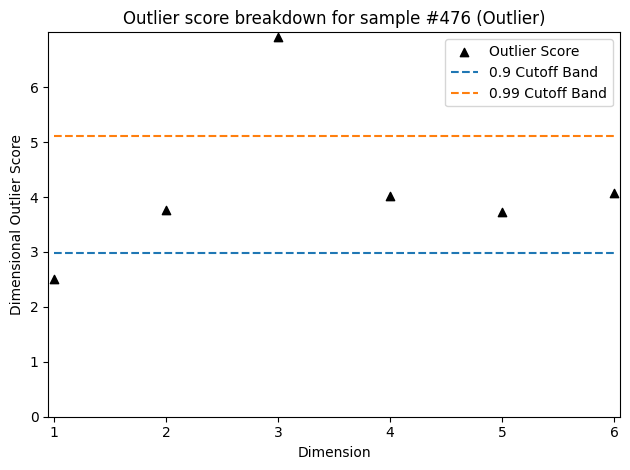

In [12]:
ecod.explain_outlier(pick_outliers[0][0])

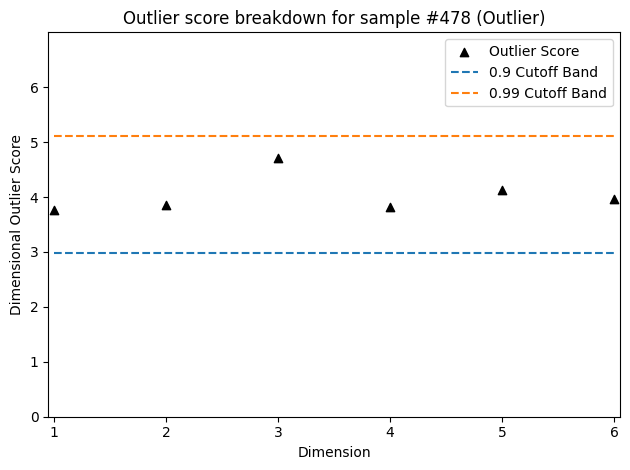

In [13]:
ecod.explain_outlier(pick_outliers[0][1])

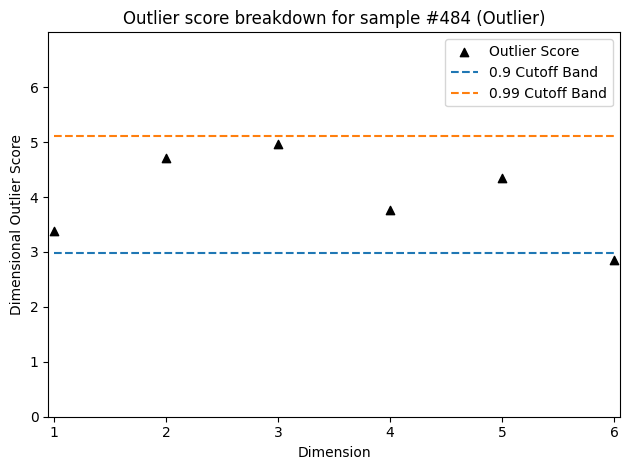

In [14]:
ecod.explain_outlier(pick_outliers[0][2])

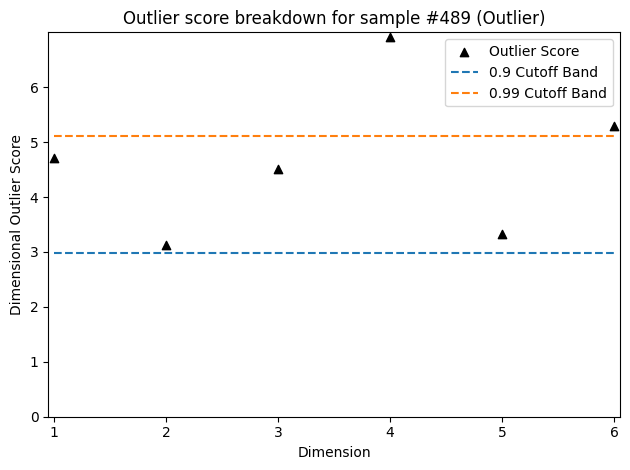

In [15]:
ecod.explain_outlier(pick_outliers[0][3])

### Step 2: Determine the threshold

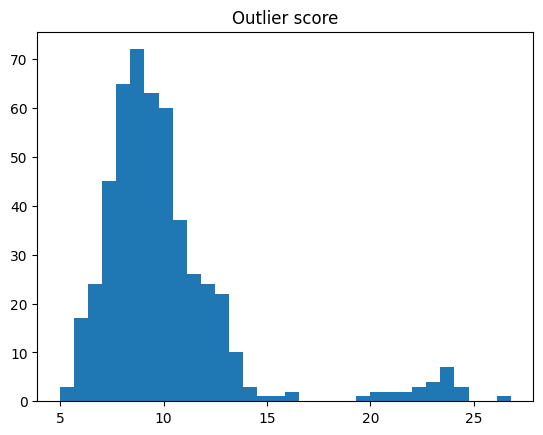

In [16]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

### Step 3: Descriptive statistics

In [26]:
threshold = 17 # Or other value from the above histogram
feature_list = ['Feature_1','Feature_2','Feature_3','Feature_4','Feature_5','Feature_6']
descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Anomaly_Score
0,Normal,475,95.0,3.00,2.99,2.99,3.01,2.99,3.02,9.40
1,Outlier,25,5.0,4.55,5.21,5.47,5.23,5.03,5.06,22.86


In [27]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Anomaly_Score
0,Normal,474,94.8,2.98,2.99,2.99,3.01,2.99,3.00,9.48
1,Outlier,26,5.2,4.90,5.42,5.15,4.97,4.99,4.79,22.47


In [28]:
def confusion_matrix(actual,pred):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': pred})
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)
confusion_matrix(y_train,y_train_pred)

Pred,0,1
Actual,,
0.0,450,25
1.0,0,25


### Two models: HBOS and ECOD

In [29]:
########
# HBOS #
########
from pyod.models.hbos import HBOS
n_bins = 50
hbos = HBOS(n_bins=n_bins, contamination=0.05)
hbos.fit(X_train)
y_train_hbos_pred = hbos.labels_
y_test_hbos_pred = hbos.predict(X_test)
y_train_hbos_scores = hbos.decision_function(X_train)
y_test_hbos_scores = hbos.decision_function(X_test)

########
# ECOD #
########
from pyod.models.ecod import ECOD
clf_name = 'ECOD'
ecod = ECOD(contamination=0.05)
ecod.fit(X_train)
y_train_ecod_pred = ecod.labels_
y_test_ecod_pred = ecod.predict(X_test)
y_train_ecod_scores = ecod.decision_scores_  # raw outlier scores
y_test_ecod_scores = ecod.decision_function(X_test)

# Thresholds
[ecod.threshold_, hbos.threshold_]

[16.320821760780653, 5.563712646460526]

In [30]:
# Put the actual, the HBO score and the ECOD score together
Actual_pred = pd.DataFrame({'Actual': y_test, 'HBOS_pred': y_test_hbos_pred, 'ECOD_pred': y_test_ecod_pred})
Actual_pred.head()
pd.crosstab(Actual_pred['HBOS_pred'],Actual_pred['ECOD_pred'])

ECOD_pred,0,1
HBOS_pred,,
0,473,1
1,0,26


In [31]:
pd.crosstab(Actual_pred['HBOS_pred'],Actual_pred['ECOD_pred'])

ECOD_pred,0,1
HBOS_pred,,
0,473,1
1,0,26


In [32]:
confusion_matrix(y_test_hbos_pred,y_test_ecod_pred)

Pred,0,1
Actual,,
0,473,1
1,0,26
